In [1]:
from src.nielsen_helpers import get_s3_files, process_files, get_regex_domains, weights_dataframe
from src.helpers import  plot_top, set_size
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy.random  as rnd
import seaborn as sns
import pandas as pd
import numpy as np
import swifter
import re

In [2]:
# Latex Configuration
from matplotlib.patches import FancyArrowPatch
import matplotlib.font_manager as font_manager
import matplotlib.transforms as transforms
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
import matplotlib.dates as dates
import scipy.stats 
import os

def handle_10(x):
    if "[10^{-3}]" not in x:
        return x
    x = x.replace("[10^{-3}]", "")
    
    pos = x.find("^")
    x = x + r'\times 10^{-3}'
    return x

params = {
    "axes.titlesize": 18,
    'axes.labelsize': 16,
    'font.size': 16,
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.family': 'arial',
    'mathtext.fontset': 'cm',
    'mathtext.rm': 'serif',
    'text.usetex': False
}

mpl.rcParams.update(params)

parlercolor = "#A50F11"
othercolor = "#377DB8"
allcolor = "#411B82"

# Loads and prepares data

In [3]:
df_desktop = pd.read_csv("/data/deplatforming/data/df_parler2_final_prep.csv.gz")
df_mobile = pd.read_csv("/data/deplatforming/data/df_parler2_final_mob_prep.csv.gz")

df_desktop["activitydatetime"] = pd.to_datetime(df_desktop["activitydatetime"])
df_mobile["activitydatetime"] = pd.to_datetime(df_mobile["activitydatetime"])

df_desktop = df_desktop.loc[df_desktop.activitydatetime >= pd.to_datetime("2020-10-01")].copy(deep=True)
df_mobile = df_mobile.loc[df_mobile.activitydatetime >= pd.to_datetime("2020-10-01")].copy(deep=True)

In [4]:

def weights_dataframe(df,
                      date_col="activitydatetime",
                      weightcol="personweight",
                      nol_id_col="mobile_id",
                      weight_cols_to_keep=["age"],
                      min_date_="2020-08-01",
                      max_date_="2021-05-31",
                      device_name='PHN',
                      is_mobile=True,
                      pathv="s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/"
                         ):

    min_date, max_date = min_date_, max_date_
    filesa = get_s3_files(min_date, max_date, is_mobile=is_mobile, pathv=pathv)
    filesn, filesw = filesa[0], filesa[1]

    it = [pd.to_datetime(min_date) - timedelta(days=1)] + list(pd.date_range(min_date, max_date, freq='M'))

    count = 0
    acc = []
    date_list = []
    number_of_panelists_per_month = []
    panelist_ids_per_month = []

    for i, j in zip(it[:-1], it[1:]):
        print(filesw[count])
        filterdate = (df[date_col] >= i + timedelta(days=1)) & (df[date_col] < j + timedelta(days=1))
        if is_mobile:
            weights = pd.read_parquet(filesw[count])
            weights = weights.loc[weights.panel_eligibility == "Y"].copy(deep=True)
            weights.loc[weights[weightcol].isna(), weightcol] = 0
            weights.loc[weights.panel_eligibility != "Y", weightcol] = 0
            weights.loc[weights.panel_status != "A", weightcol] = 0
            weights.loc[weights["device_name"] != device_name, weightcol] = 0
            weights.rename({"mobileid": nol_id_col}, axis=1, inplace=True)

        else:
            weights = pd.read_csv(filesw[count])
            weights = weights.loc[weights.combo_visitors_weight > 0].copy(deep=True)
        date_list.append(i +  timedelta(days=1))
        number_of_panelists_per_month.append(len(weights[weights[weightcol] > 0]))
        panelist_ids_per_month.append(set(weights[weights[weightcol] > 0][nol_id_col]))

        tmp = df[filterdate].copy(deep=True).merge(weights[[nol_id_col, weightcol] + weight_cols_to_keep],
                                                   how="left",
                                                   on=nol_id_col, validate="m:1")
        acc.append(tmp)
        count += 1
    ret = pd.concat(acc).reset_index()

    ret = ret.loc[(ret[date_col] >= pd.to_datetime(min_date_) ) &
                  (ret[date_col] < pd.to_datetime(max_date_))].copy(deep=True)
    return ret, date_list, number_of_panelists_per_month, panelist_ids_per_month

## Weights data

In [5]:
ocol = ["age", "gender_id", "race_id", "education_id", "income_group_id", "hispanic_origin_id"]
pathv = "s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/"

# Fringe + Parler
w, _, _, _ = weights_dataframe(df_desktop,
min_date_="2020-10-01",
weight_cols_to_keep=ocol,
nol_id_col="nol_id",
weightcol="combo_visitors_weight",
is_mobile=False,
pathv=pathv)

w["viewduration_w"] = w["viewduration"] * w["combo_visitors_weight"]

s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/NOL_Demo/2020/10/nol_demos_202010.csv


/data/anaconda3/lib/python3.9/site-packages/charset_normalizer/api.py:105: UserWarning: Trying to detect encoding from a tiny portion of (29) byte(s).
  warn('Trying to detect encoding from a tiny portion of ({}) byte(s).'.format(length))


s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/NOL_Demo/2020/11/nol_demos_202011.csv
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/NOL_Demo/2020/12/nol_demos_202012.csv
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/NOL_Demo/2021/1/nol_demos_202101.csv
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/NOL_Demo/2021/2/nol_demos_202102.csv
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/NOL_Demo/2021/3/nol_demos_202103.csv
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/NOL_Demo/2021/4/nol_demos_202104.csv
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/NOL_Demo/2021/5/nol_demos_202105.csv


In [6]:
def f(df):
    
    df["pct_18_20"] = ((df.age >= 18) & (df.age <= 20)).sum() 
    df["pct_21_44"] = ((df.age >= 21) & (df.age <= 44)).sum()
    df["pct_45_64"] =  ((df.age >= 45) & (df.age <= 64)).sum()
    df["pct_65p"] = (df.age >= 65).sum()
    
    # gender/race/ethnicity
    df["Women"] = (df.gender_id == 2)
    df["Black"] = (df.race_id == 2)
    df["AAPI"] = (df.race_id == 3)
    df["AIAN"] = (df.race_id == 4)
    df["Hispanic"] = ~((df.hispanic_origin_id == -1) | (df.hispanic_origin_id == 1))

    # education
    df["HS_or_less"] = (df.education_id == 1) | (df.education_id == 2) | (df.education_id == 3)
    df["Some_college"] = (df.education_id == 4) | (df.education_id == 5)
    df["College_graduate"] = (df.education_id == 6)
    df["Graduate+"] = (df.education_id > 6)

    # income
    df["inc0to25k"] = (df.income_group_id == 1)
    df["inc25to50k"] = (df.income_group_id == 2)
    df["inc50to75k"] = (df.income_group_id == 3)
    df["inc75to100k"] = (df.income_group_id == 4)
    df["inc100kp"] = (df.income_group_id == 5) | (df.income_group_id == 6)
    
f(w)

colsr = ["Women", "Black", "AAPI", "AIAN", 
    "Hispanic", "HS_or_less", "Some_college",
    "College_graduate", "Graduate+", "inc0to25k", 
    "inc25to50k", "inc50to75k", "inc75to100k", "inc100kp",
    "pct_18_20", "pct_21_44", "pct_45_64", "pct_65p"]
w = w.drop(ocol, axis=1)

In [7]:
ocols = ['age', 'gender', 'marital_status', 'edulevelid', 'educationdesc', 'incomeid',
         'incomedesc', 'emplstatusid', 'employmentstatusdesc', 'raceid',
         'racedesc', 'hispanicoriginid', 'hispanicorigindesc',
         'agegroup', 'spanish_language1']

# Fringe + Parler
w_mob, _, _, _ = weights_dataframe(df_mobile,
    nol_id_col="nol_id",
    weight_cols_to_keep=ocols)
w_mob["viewduration_w"] = w_mob["viewduration"] * w_mob["personweight"]

s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/August 2020/demographics.pq
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/September 2020/demographics.pq
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/October 2020/demographics.pq
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/November 2020/demographics.pq
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/December 2020/demographics.pq
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/January 2021/demographics.pq
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/February 2021/demographics.pq
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/March 2021/demographics.pq
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/April 2021/demographics.pq
s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/tmp/May 2021/demographics.pq


In [8]:
def f(df):
    
    df["pct_18_20"] = ((df.age >= 18) & (df.age <= 20)).sum() 
    df["pct_21_44"] = ((df.age >= 21) & (df.age <= 44)).sum()
    df["pct_45_64"] =  ((df.age >= 45) & (df.age <= 64)).sum()
    df["pct_65p"] = (df.age >= 65).sum()
    
    # gender/race/ethnicity
    df["Women"] = (df.gender == 'F')
    df["Black"] = (df.raceid == 86)
    df["AAPI"] = (df.raceid == 88)
    df["AIAN"] = (df.raceid == 89)
    df["Hispanic"] = (df.hispanicoriginid == 83)

    # education
    df["HS_or_less"] = (df.edulevelid == 101) | (df.edulevelid == 102) | (df.edulevelid == 103)
    df["Some_college"] = (df.edulevelid == 104) | (df.edulevelid == 105)
    df["College_graduate"] = (df.edulevelid == 106)
    df["Graduate+"] = (df.edulevelid > 106)

    # income
    df["inc0to25k"] = (df.incomeid == 21)
    df["inc25to50k"] = (df.incomeid == 23)
    df["inc50to75k"] = (df.incomeid == 24)
    df["inc75to100k"] = (df.incomeid == 25)
    df["inc100kp"] = (df.incomeid > 25)
    
f(w_mob)

colsr = ["Women", "Black", "AAPI", "AIAN", "Hispanic", "HS_or_less", "Some_college", "College_graduate",
         "Graduate+", "inc0to25k", "inc25to50k", "inc50to75k", "inc75to100k", "inc100kp",
        "pct_18_20", "pct_21_44", "pct_45_64", "pct_65p"]
w_mob = w_mob.drop(ocols, axis=1)

In [9]:
mainstream_platforms = [
    "facebook", "youtube", "instagram", "tiktok", "twitter",
    "reddit", "pinterest", "linkedin", "whatsapp", "nextdoor", "snapchat", "mainstream"
]

fringe_platforms = [
    "fringe", 
    "telegram", 
    "locals", "gab", "rumble", "bitchute", 
    "8kun", "mewe", "dlive", "minds", "4chan", "parler",
]

#  mainstream_platforms + fringe_platforms +
for platform in mainstream_platforms + fringe_platforms + ["fringe_all", "other"]:        
        if platform not in ["fringe", "mainstream", "fringe_all"]:
            w[platform] = w["platform"] == platform
            w_mob[platform] = w_mob["platform"] == platform
        elif platform == "fringe":
            w[platform] =  w["platform"].apply(lambda x: x in fringe_platforms[:-1])
            w_mob[platform] =  w_mob["platform"].apply(lambda x: x in fringe_platforms[:-1])
        elif platform == "mainstream":
            w[platform] =  w["platform"].apply(lambda x: x in mainstream_platforms)
            w_mob[platform] =  w_mob["platform"].apply(lambda x: x in mainstream_platforms)
        elif platform == "fringe_all":
            w[platform] =  w["platform"].apply(lambda x: x in fringe_platforms)
            w_mob[platform] =  w_mob["platform"].apply(lambda x: x in fringe_platforms)

# Gets CEM weights

In [10]:
dems_mob = w_mob[["nol_id", "is_treat"] + colsr].groupby("nol_id").first()
dems_desktop = w[["nol_id", "is_treat"] + colsr].groupby("nol_id").first()
dems_desktop = dems_desktop.reset_index()
dems_mob = dems_mob.reset_index()

In [11]:
df_pre_activity = {}
for col in ["fringe_all", "mainstream", "other"]:
    pre_period =(w.activitydatetime <= pd.to_datetime("2020-12-31")) &\
                 (w.activitydatetime >= pd.to_datetime("2020-12-01"))
    tmp = dict(w[w[col] & pre_period].groupby("nol_id").viewduration.sum())
    dems_desktop["pre_" + col] = dems_desktop["nol_id"].apply(lambda x: tmp[x] if x in tmp else 0)
    
    pre_period =(w_mob.activitydatetime <= pd.to_datetime("2020-12-31")) &\
                 (w_mob.activitydatetime >= pd.to_datetime("2020-12-01"))
    tmp = dict(w_mob[w_mob[col] &  pre_period].groupby("nol_id").viewduration.sum())
    dems_mob["pre_" + col] = dems_mob["nol_id"].apply(lambda x: tmp[x] if x in tmp else 0)


In [12]:
dems_mob.to_csv("./data/demographics_mobile.csv")
dems_desktop.to_csv("./data/demographics_desktop.csv")

# Panel-level activity statistics

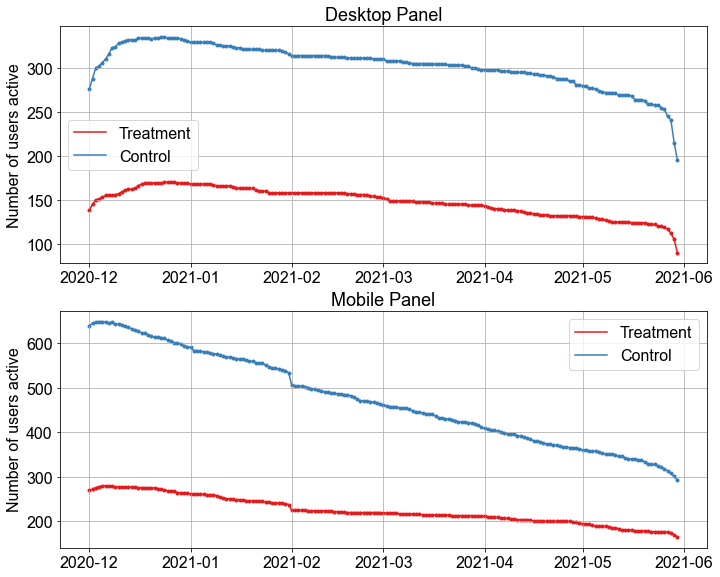

In [14]:
fig, axs_ = plt.subplots(2, 1, figsize=(10,8), sharex=False)
dict_treat_active = {}
dict_control_active = {}
dict_activity = {}

for axs, df, setting in zip(axs_, [w, w_mob], ["desktop", "mobile"]):
    tmp = df.groupby(["is_treat", "nol_id"]).activitydatetime.agg(["min", "max"]).reset_index()
    min_date = tmp["min"].min()
    max_date = tmp["max"].max()
    x = []

    y_treat = []
    y_control = []
    for i in pd.date_range(min_date, max_date, freq="D"):
        i = pd.to_datetime(i.date())
        # print(i)
        acc_treat = (tmp["min"] <= i + timedelta(days=1)) & (tmp["max"] >= i) & (tmp["is_treat"] == 1)
        acc_control = (tmp["min"] <= i + timedelta(days=1)) & (tmp["max"] >= i) & (tmp["is_treat"] == 0)
        x.append(i)
        
        y_treat.append(acc_treat.sum())
        dict_treat_active[i, setting] = acc_treat.sum()
    
        y_control.append(acc_control.sum())
        dict_control_active[i, setting] = acc_control.sum()
        
        for idx, userc in tmp[acc_treat].iterrows():
            userc = dict(userc)
            dict_activity[(userc['nol_id'], 1, i, setting)] = True
            
        for idx, userc in tmp[acc_control].iterrows():
            userc = dict(userc)
            dict_activity[(userc['nol_id'], 0, i, setting)] = True

    axs.plot(x, y_treat, color="#e41a1c", label="Treatment")
    axs.scatter(x, y_treat, color="#e41a1c", marker=".")
    axs.plot(x, y_control, color="#377eb8", label="Control")
    axs.scatter(x, y_control, color="#377eb8", marker=".")
    axs.set_ylabel("Number of users active")
    axs.set_title("Mobile Panel" if setting == "mobile" else "Desktop Panel")
    axs.xaxis.grid()
    axs.yaxis.grid()
    axs.legend()

    set_size(fig, (10,  8))

# Creates different setups

In [43]:
df_tmp = []

for mask_str in ["parler", "fringe", "mainstream", "fringe_all"]:
    for df_setting, setting in [(w_mob, "mobile"), (w, "desktop")]: 
        # print(mask_str, setting)
        mask = df_setting[mask_str]
        
        tmp = df_setting[mask].groupby(["nol_id", "is_treat", pd.Grouper(key="activitydatetime", freq="D")] 
                                       + colsr).sum()
        tmp2 = tmp.reset_index()
        display(tmp2)
        tmp_all = df_setting.groupby(["nol_id", "is_treat", pd.Grouper(key="activitydatetime", freq="D")] 
                                    + colsr).sum()

        for date, is_treat in set(list(zip(tmp2.activitydatetime.values, tmp2.is_treat.values))):
            if date < pd.to_datetime("2020-10-01"):
                continue

            for nol_id in set(tmp2.nol_id.values):
                if (nol_id, int(is_treat), pd.to_datetime(date), setting) not in dict_activity:
                    continue
                try:
                    dur = tmp.loc[(nol_id, is_treat, date), "viewduration"]
                    dur_rel = dur / tmp_all.loc[(nol_id, is_treat, date), "viewduration"]
                    df_tmp.append({
                        "date": date,
                        "post": date >= pd.to_datetime("2021-01-11"),
                        "post2": date >= pd.to_datetime("2020-12-15"),
                        "nol_id": nol_id,
                        "treat": is_treat,
                        "duration": dur,
                        "count": 1,
                        "dur_rel": dur_rel,
                        "norm":  tmp_all.loc[(nol_id, is_treat, date), "viewduration"],
                        "mask": mask_str,
                        "setting": setting
                    })
                except:
                    df_tmp.append({
                        "date": date,
                        "post": date >= pd.to_datetime("2021-01-11"),
                        "post2": date >= pd.to_datetime("2020-12-15"),
                        "nol_id": nol_id,
                        "treat": is_treat,
                        "duration": 0,
                        "count": 0,
                        "dur_rel": 0,
                        "norm": 0,
                        "mask": mask_str,
                        "setting": setting
                    })

df_tmp = pd.DataFrame(df_tmp)

In [26]:
df_weigths = pd.concat([pd.read_csv("./data/desk.csv"), pd.read_csv("./data/mob.csv")])
df_tmp2 = df_tmp.merge(df_weigths, how="left", on="nol_id", validate="m:1").dropna()
df_tmp2 = df_tmp2[(df_tmp2.date >= pd.to_datetime("2020-12-01")) & 
                 (df_tmp2.date <= pd.to_datetime("2021-02-14"))]
df_tmp2["count_w"] = df_tmp2["count"] * df_tmp2["weights"]  


In [27]:
df_tmp2["duration"] = df_tmp2["duration"].astype("int") 
df_tmp2["duration_w"] = df_tmp2["duration"].astype("int") * df_tmp2["weights"]  
df_tmp2["dur_rel"] = df_tmp2["dur_rel"].astype("float")


In [28]:
df_tmp2 = df_tmp2.drop(['Unnamed: 0', 'X', 'is_treat',
       'Women', 'Black', 'AAPI', 'AIAN', 'Hispanic', 'HS_or_less',
       'Some_college', 'College_graduate', 'Graduate.', 'inc0to25k',
       'inc25to50k', 'inc50to75k', 'inc75to100k', 'inc100kp', 'pre_fringe_all',
       'pre_mainstream', 'pre_other', "subclass"], axis=1)

# Simplified plots

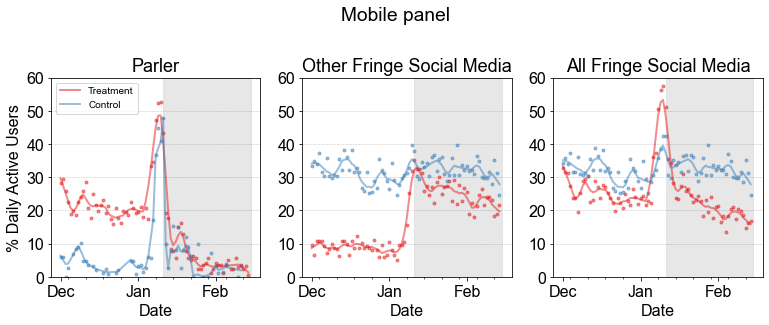

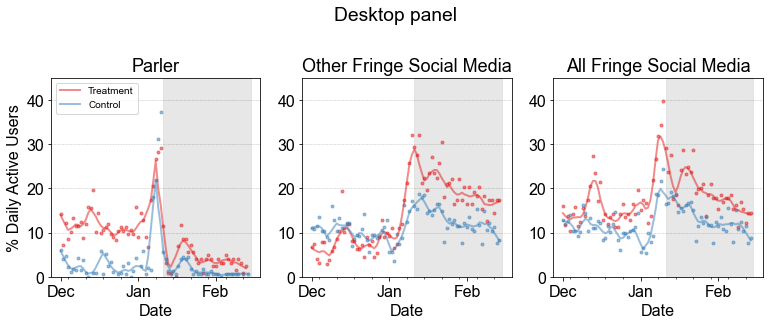

In [30]:
import statsmodels.api as sm



myFmt = dates.DateFormatter('%b')

for setting in ["mobile", "desktop"]:

    fig = plt.figure(constrained_layout=False, figsize=(10.68, 4.5))
    axs = fig.subplot_mosaic([["parler", "fringe", "fringe_all"]],
                            gridspec_kw={'wspace': 0.2, "hspace": 0.15})
    
    for mask in ["fringe", "fringe_all", "parler"]:
        
        k = "count_w"
        df_wls = df_tmp2[(df_tmp2.setting == setting) & (df_tmp2["mask"] == mask)]
        ax = axs[mask]
        df_wls_ = df_wls.groupby([pd.Grouper(key="date", freq="D"), 
                                  "treat"])[k].sum().reset_index()
        df_wls_s = df_wls.groupby([pd.Grouper(key="date", freq="D"), 
                                  "treat"])["weights"].sum().reset_index()
        

        df_wls_treat = df_wls_[df_wls_.treat == 1].set_index("date")[k]
        df_wls_treat = df_wls_treat/df_wls_s[df_wls_s.treat == 1].set_index("date")["weights"]
    
        df_wls_control = df_wls_[df_wls_.treat == 0].set_index("date")[k]
        df_wls_control = df_wls_control/df_wls_s[df_wls_s.treat == 0].set_index("date")["weights"]
        

        ax.scatter(df_wls_treat.index, df_wls_treat * 100, alpha=0.5, marker=".", color="#e41a1c")
        ax.scatter(df_wls_control.index, df_wls_control * 100, alpha=0.5, marker=".", color="#377eb8")
        ax.axvspan(pd.to_datetime("2021-01-11"), pd.to_datetime("2021-02-15"), color="#DDDDDD", alpha=0.7,
                   zorder=-2)        
  

        for df, label, color, period_min, period_max in zip(
            [df_wls_treat, df_wls_control],
            ["Treatment", "Control"],
            ["#e41a1c", "#377eb8"],
            ["2020-12-01", "2020-12-01"],
            ["2021-02-15", "2021-02-15"]):
                df = df[(df.index >= pd.to_datetime(period_min)) &
                        (df.index <= pd.to_datetime(period_max))]
                lowess = sm.nonparametric.lowess(df.values * 100, df.index, frac=.1)
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]

                ax.plot(df.index, lowess_y , label=label, color=color, alpha=0.5, lw=2)


        
        ax.set_ylim(bottom=0)
        ax.xaxis.set_major_formatter(myFmt)
        ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))
        ax.xaxis.set_minor_locator(dates.DayLocator(interval=7))
        
        if setting == "desktop":
            ax.set_ylim(top=45)
        else:
            ax.set_ylim(top=60)
            
        for xmaj in ax.yaxis.get_majorticklocs():
            ax.axhline(y=xmaj, ls='--', alpha=0.25, lw=0.5, color="black", zorder=-2)     
            ax.set_xlabel("Date")
    axs["parler"].set_ylabel("% Daily Active Users")
    axs["parler"].legend(fontsize=10)
    axs["parler"].set_title("Parler")
    axs["fringe"].set_title("Other Fringe Social Media")
    axs["fringe_all"].set_title("All Fringe Social Media")
    
    if setting == "desktop":
        fig.suptitle("Desktop panel", y=1.15)
    else:
        fig.suptitle("Mobile panel", y=1.15)
    set_size(fig, (10.68, 4.5))
    fig.savefig("./images/userlevel{}.pdf".format(setting), bbox_inches="tight", dpi=300)
    fig.savefig("./images/userlevel{}.png".format(setting), bbox_inches="tight", dpi=300)



,mask_str,setting,lower,upper,meanv,pvalues
0,parler,mobile,-0.217164,-0.135168,-0.176166,3.704938e-17
1,parler,desktop,-0.104170,-0.044307,-0.074238,1.166619e-06
2,fringe,mobile,0.101792,0.216912,0.159352,5.761847e-08
3,fringe,desktop,0.058085,0.159146,0.108615,2.520441e-05
4,fringe_all,mobile,-0.085779,0.018935,-0.033422,2.108821e-01
5,fringe_all,desktop,-0.022669,0.066074,0.021702,3.377480e-01
6,mainstream,mobile,-0.037879,0.042905,0.002513,9.029484e-01
7,mainstream,desktop,-0.082187,0.025577,-0.028305,3.031971e-01


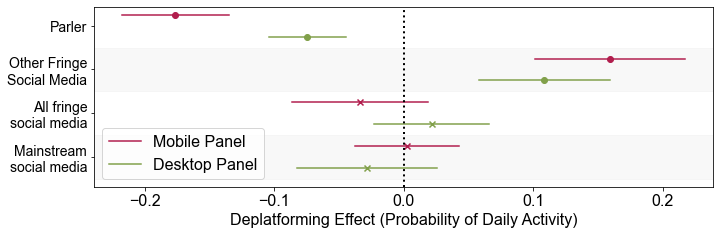

In [37]:
import statsmodels.formula.api as smf
acc_plot = []
for mask_str in ["parler", "fringe", "fringe_all", "mainstream"]:
    for setting in ["mobile", "desktop"]:
        df_wls = df_tmp2[(df_tmp2.setting == setting) & (df_tmp2["mask"] == mask_str)]
        df_wls = df_wls[~((df_wls.date >= pd.to_datetime("2021-01-01")) & 
                 (df_wls.date <= pd.to_datetime("2021-01-11")))]
        res = smf.wls(formula='count ~   post * treat ', 
                      data=df_wls).fit(cov_type='cluster', 
                                        cov_kwds={'groups': df_wls['nol_id']}, 
                                        weights=df_wls.weights)
        res.summary()
        lower, upper = res.conf_int().loc["post[T.True]:treat"].values
        meanv = res.params["post[T.True]:treat"]
        acc_plot.append({
            "mask_str": mask_str,
            "setting": setting,
            "lower": lower,
            "upper": upper,
            "meanv": meanv,
            "pvalues": res.pvalues["post[T.True]:treat"]
        })
acc_plot = pd.DataFrame(acc_plot)
display(acc_plot)
fig, axs = plt.subplots(1, figsize=(10, 3))
for idx, row in acc_plot.iterrows():
    idx = 7- idx
    row = dict(row)
    nsig = row["lower"] < 0 and row["upper"] > 0
    lab = "Desktop Panel" if row["setting"] == "desktop" else "Mobile Panel"
    axs.plot([row["lower"], row["upper"]], [idx, idx], 
             color="#81a04a" if row["setting"] == "desktop" else "#b11d4d",
             label= lab if idx < 2 else None,
            )
    axs.scatter([row["meanv"]], [idx], 
                 color="#81a04a" if row["setting"] == "desktop" else "#b11d4d",
                   marker="x" if nsig else "o")

    
axs.axvline(0, color="black", ls=":", lw=2)
axs.axhspan(ymin=-0.5, ymax=1.5, color="#DDDDDD", alpha=0.2,
           zorder=-2)
axs.axhspan(ymin=3.5, ymax=5.5, color="#DDDDDD", alpha=0.2,
           zorder=-2) 
axs.set_yticks([0.5, 2.5, 4.5, 6.5])
axs.set_yticklabels(["Parler", 
                "Other Fringe\nSocial Media", 
                "All fringe\nsocial media", 
                "Mainstream\nsocial media"][::-1], size=14)
axs.set_xlabel("Deplatforming Effect (Probability of Daily Activity)")
axs.legend()
set_size(fig, (10,  3.25))
fig.savefig("./images/userleveldid.pdf".format(setting), bbox_inches="tight", dpi=300)
fig.savefig("./images/userleveldid.png".format(setting), bbox_inches="tight", dpi=300)


# Main plot

In [34]:
import matplotlib.patheffects as pe

fontsize_small = 14
fontsize_text = 16
fontsize_large = 18

def auxtexttreat(tmp, ax, writet=False):
    lbt = tmp.head(31).mean() * 100
    ubt = tmp.tail(-31).mean() * 100
    pes = [pe.Stroke(linewidth=2, foreground='w'), pe.Normal()]

    ax.plot([pd.to_datetime("2020-12-01"), pd.to_datetime("2020-12-31")], 
             [lbt, lbt], lw=2, color="#e41a1c", ls="--", path_effects=pes)
    ax.plot([pd.to_datetime("2021-01-12"), pd.to_datetime("2021-02-14")], 
             [ubt, ubt], lw=2, color="#e41a1c", ls="--", path_effects=pes)

    if writet:
        ax.plot([pd.to_datetime("2021-01-08"), pd.to_datetime("2021-01-08")], [lbt, ubt], 
            color="#e41a1c",  lw=2, path_effects=pes)
        txt = ax.text(pd.to_datetime("2021-01-08"),(lbt + ubt)/2 + 2, 
                      "  $\Delta$ treated", ha="left", va="center",
                color="#e41a1c", fontsize=fontsize_small, fontweight="heavy")
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

def auxtextcontrol(tmp, ax, writet=False):
    lbc = tmp.head(31).mean() * 100
    ubc = tmp.tail(-31).mean() * 100
    pes = [pe.Stroke(linewidth=2, foreground='w'), pe.Normal()]

    ax.plot([pd.to_datetime("2020-12-01"), pd.to_datetime("2020-12-31")], 
             [lbc, lbc], lw=2, color="#377eb8", ls="--", path_effects=pes)
    ax.plot([pd.to_datetime("2021-01-12"), pd.to_datetime("2021-02-14")], 
             [ubc, ubc], lw=2, color="#377eb8", ls="--", path_effects=pes)

    
    if writet:
        ax.plot([pd.to_datetime("2021-01-04"), pd.to_datetime("2021-01-04")], [lbc, ubc], 
            color="#377eb8",  lw=2, path_effects=pes)
        txt = ax.text(pd.to_datetime("2021-01-04"),(lbc + ubc)/2,
                      "$\Delta$ control  ", ha="right", va="center",
                color="#377eb8", fontsize=fontsize_small, fontweight="heavy")
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])




A 0.108615447751985 0.05808511027976811 0.15914578522420192
B 0.15935162304935063 0.10179150240846899 0.21691174369023228
C -0.07423811658477743 -0.10416967747822188 -0.044306555691332974
D -0.17616595633314178 -0.2171638063224745 -0.13516810634380905


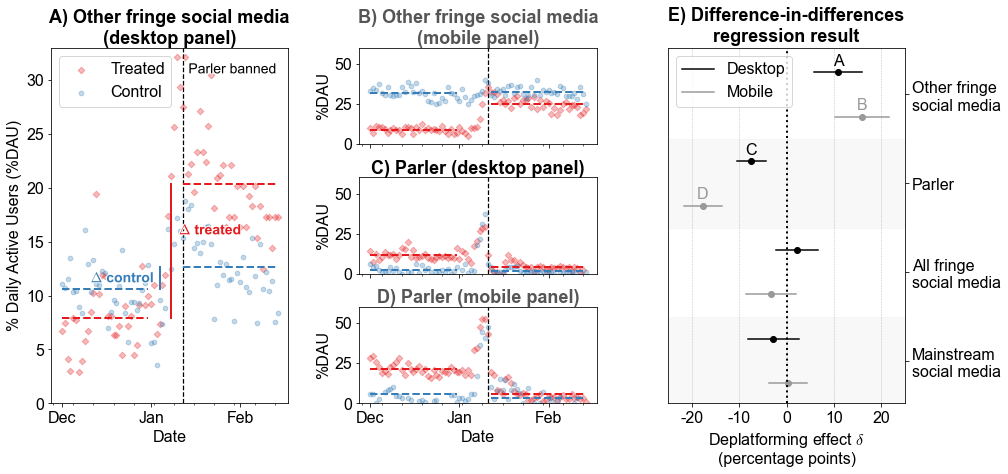

In [35]:
import matplotlib.patheffects as PathEffects

fig = plt.figure(constrained_layout=False, figsize=(14, 6.5))
axs = fig.subplot_mosaic([["fringe", "fringemobile", "did"],
                         ["fringe", "parlerdesktop", "did"],
                         ["fringe", "parlermobile", "did"]],
                        gridspec_kw={'wspace': 0.3, "hspace": 0.35})


myFmt = dates.DateFormatter('%b')

    
ax = axs["fringe"]
k = "count_w"
df_wls = df_tmp2[(df_tmp2.setting == "desktop") & (df_tmp2["mask"] == "fringe")]
df_wls_ = df_wls[~((df_wls.date >= pd.to_datetime("2021-01-01")) & 
         (df_wls.date <= pd.to_datetime("2021-01-11")))]
df_wls_ = df_wls.groupby([pd.Grouper(key="date", freq="D"), 
                          "treat"])[k].sum().reset_index()
df_wls_s = df_wls.groupby([pd.Grouper(key="date", freq="D"), 
                          "treat"])["weights"].sum().reset_index()


df_wls_treat = df_wls_[df_wls_.treat == 1].set_index("date")[k]
df_wls_treat = df_wls_treat/df_wls_s[df_wls_s.treat == 1].set_index("date")["weights"]

df_wls_control = df_wls_[df_wls_.treat == 0].set_index("date")[k]
df_wls_control = df_wls_control/df_wls_s[df_wls_s.treat == 0].set_index("date")["weights"]

ax.scatter(df_wls_treat.index, df_wls_treat * 100, alpha=.3, marker="D", color="#e41a1c", label="Treated",
          s=22)
ax.scatter(df_wls_control.index, df_wls_control * 100, alpha=.3, marker="o", color="#377eb8", label="Control",
         s=22)

df_wls = df_tmp2[(df_tmp2.setting == setting) & (df_tmp2["mask"] == "fringe")]
df_wls_f = df_wls[~((df_wls.date >= pd.to_datetime("2021-01-01")) & 
         (df_wls.date <= pd.to_datetime("2021-01-11")))]
 
tmp = df_wls_treat[~((df_wls_treat.index >= pd.to_datetime("2021-01-01")) & 
         (df_wls_treat.index <= pd.to_datetime("2021-01-11")))]
auxtexttreat(tmp, ax, writet=True)

tmp = df_wls_control[~((df_wls_control.index >= pd.to_datetime("2021-01-01")) & 
         (df_wls_control.index <= pd.to_datetime("2021-01-11")))]
auxtextcontrol(tmp, ax, writet=True)

ax.axvline(pd.to_datetime("2021-01-12"), color="black", ls="--", zorder=-1, lw=1.25)
txt = ax.text(pd.to_datetime("2021-01-14"), 31, "Parler banned", size=fontsize_small, ha="left", va="center")
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

ax.set_ylabel("% Daily Active Users (%DAU)")

ax.set_title("A) Other fringe social media\n(desktop panel)", pad=0, color="#000", fontweight="bold")
ax.set_ylim(bottom=0, top=33)
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))
ax.xaxis.set_minor_locator(dates.DayLocator(interval=7))
# for xmaj in ax.yaxis.get_majorticklocs():
#     ax.axhline(y=xmaj, ls='--', alpha=0.25, lw=0.5, color="black", zorder=-2)     
ax.set_xlabel("Date")
ax.legend(fontsize=fontsize_text, loc="upper left")
    
for mask, setting in [("fringe", "mobile"), ("parler", "desktop"), ("parler", "mobile")]:

    k = "count_w"
    df_wls = df_tmp2[(df_tmp2.setting == setting) & (df_tmp2["mask"] == mask)]
    ax = axs[mask+setting]
    df_wls_ = df_wls.groupby([pd.Grouper(key="date", freq="D"), 
                              "treat"])[k].sum().reset_index()
    df_wls_s = df_wls.groupby([pd.Grouper(key="date", freq="D"), 
                              "treat"])["weights"].sum().reset_index()


    df_wls_treat = df_wls_[df_wls_.treat == 1].set_index("date")[k]
    df_wls_treat = df_wls_treat/df_wls_s[df_wls_s.treat == 1].set_index("date")["weights"]

    df_wls_control = df_wls_[df_wls_.treat == 0].set_index("date")[k]
    df_wls_control = df_wls_control/df_wls_s[df_wls_s.treat == 0].set_index("date")["weights"]
    tmp = df_wls_treat[~((df_wls_treat.index >= pd.to_datetime("2021-01-01")) & 
             (df_wls_treat.index <= pd.to_datetime("2021-01-11")))]


    ax.scatter(df_wls_treat.index, df_wls_treat * 100, alpha=.3, marker="D", color="#e41a1c", label="Treated",
              s=22)
    ax.scatter(df_wls_control.index, df_wls_control * 100, alpha=.3, marker="o", color="#377eb8", label="Control",
             s=22)
    ax.axvline(pd.to_datetime("2021-01-11"), color="black", ls="--", zorder=-1, lw=1.25)
    tmp = df_wls_treat[~((df_wls_treat.index >= pd.to_datetime("2021-01-01")) & 
             (df_wls_treat.index <= pd.to_datetime("2021-01-11")))]
    auxtexttreat(tmp, ax, writet=False)

    tmp = df_wls_control[~((df_wls_control.index >= pd.to_datetime("2021-01-01")) & 
             (df_wls_control.index <= pd.to_datetime("2021-01-11")))]
    auxtextcontrol(tmp, ax, writet=False)

    ax.set_ylim(bottom=0)
    ax.set_yticks([0, 25, 50])
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))
    ax.xaxis.set_minor_locator(dates.DayLocator(interval=7))
    ax.set_ylabel("%DAU")

    ax.set_ylim(top=60)

#     for xmaj in ax.yaxis.get_majorticklocs():
#         ax.axhline(y=xmaj, ls='--', alpha=0.25, lw=0.5, color="black", zorder=-2)     
    if mask+setting != "parlermobile":
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Date")
axs["fringemobile"].set_title("B) Other fringe social media\n(mobile panel)", pad=0, color="#555" , fontweight="bold")
axs["parlerdesktop"].set_title("C) Parler (desktop panel)", pad=0, color="#000", fontweight="bold")
axs["parlermobile"].set_title("D) Parler (mobile panel)", pad=0, color="#555", fontweight="bold")

import statsmodels.formula.api as smf
acc_plot = []
for mask_str in ["fringe", "parler", "fringe_all", "mainstream"]:
    for setting in ["desktop", "mobile"]:
        df_wls = df_tmp2[(df_tmp2.setting == setting) & (df_tmp2["mask"] == mask_str)]
        df_wls = df_wls[~((df_wls.date >= pd.to_datetime("2021-01-01")) & 
                 (df_wls.date <= pd.to_datetime("2021-01-11")))]
        res = smf.wls(formula='count ~   post * treat ', 
                      data=df_wls).fit(cov_type='cluster', 
                                        cov_kwds={'groups': df_wls['nol_id']}, 
                                        weights=df_wls.weights)
        res.summary()
        lower, upper = res.conf_int().loc["post[T.True]:treat"].values
        meanv = res.params["post[T.True]:treat"]
        acc_plot.append({
            "mask_str": mask_str,
            "setting": setting,
            "lower": lower,
            "upper": upper,
            "meanv": meanv,
            "pvalues": res.pvalues["post[T.True]:treat"]
        })

acc_plot = pd.DataFrame(acc_plot)
ax = axs["did"]
letters = {4: "D", 5: "C", 6:"B", 7:"A"}
for idx, row in acc_plot.iterrows():
    idx = 7- idx
    row = dict(row)
    nsig = row["lower"] < 0 and row["upper"] > 0
    lab = "Desktop" if row["setting"] == "desktop" else "Mobile"
    ax.plot([row["lower"], row["upper"]], [idx, idx], 
        color="#000" if row["setting"] == "desktop" else "#999",
        label= lab if idx < 2 else None)
    ax.scatter([row["meanv"]], [idx], 
        color="#000" if row["setting"] == "desktop" else "#999")
    
    
    if idx >= 4:
        ax.text(row["meanv"], idx + 0.15, letters[idx], ha="center",
                 color="#000" if row["setting"] == "desktop" else "#999")
        print(letters[idx], row["meanv"], row["lower"], row["upper"])

ax.axvline(0, color="black", ls=":", lw=2)
ax.axhspan(ymin=-0.5, ymax=1.5, color="#DDDDDD", alpha=0.2,
           zorder=-2)
ax.axhspan(ymin=3.5, ymax=5.5, color="#DDDDDD", alpha=0.2,
           zorder=-2) 
ax.set_yticks([0.5, 2.5, 4.5, 6.5])
ax.set_yticklabels([
                "Other fringe\nsocial media", 
                "Parler", 
                "All fringe\nsocial media", 
                "Mainstream\nsocial media"][::-1])
ax.set_xlabel("Deplatforming effect $\delta$\n(percentage points)")
ax.legend(loc="upper left", fontsize=fontsize_text)
ax.set_title("E) Difference-in-differences\nregression result", fontweight="bold")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlim([-0.25, 0.25])
ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.set_xticklabels(["-20", "-10", "0", "10", "20"])
ax.set_ylim([-0.45, 7.55])
for xmaj in ax.xaxis.get_majorticklocs():
    ax.axvline(x=xmaj, ls='--', alpha=0.25, lw=0.5, color="black", zorder=-2)
    
    
     
set_size(fig, size=(14, 6.5))
fig.savefig("./images/userleveldid.pdf".format(setting), bbox_inches="tight", dpi=300)
fig.savefig("./images/userleveldid.png".format(setting), bbox_inches="tight", dpi=300)


# Placebo check!

This considers pre- and post-periods before the actual intervention!

-0.023025858846764464
-0.015953272167531268
0.008842113074126903
0.017374817591240557
-0.018368335431157748
-0.005083780441270041
0.003514980331910514
-0.005245652212324148


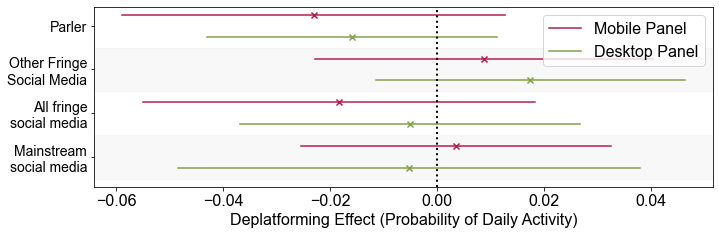

In [42]:
import statsmodels.formula.api as smf
acc_plot = []
for mask_str in ["parler", "fringe", "fringe_all", "mainstream"]:
    for setting in ["mobile", "desktop"]:
        df_wls = df_tmp2[(df_tmp2.setting == setting) & (df_tmp2["mask"] == mask_str)]
        df_wls = df_wls[((df_wls.date >= pd.to_datetime("2020-12-01")) & 
                 (df_wls.date <= pd.to_datetime("2021-01-01")))]
        res = smf.wls(formula='count ~   post2 * treat ', 
                      data=df_wls).fit(cov_type='cluster', 
                                        cov_kwds={'groups': df_wls['nol_id']}, 
                                        weights=df_wls.weights)
        res.summary()
        lower, upper = res.conf_int().loc["post2[T.True]:treat"].values
        meanv = res.params["post2[T.True]:treat"]
        acc_plot.append({
            "mask_str": mask_str,
            "setting": setting,
            "lower": lower,
            "upper": upper,
            "meanv": meanv,
            "pvalues": res.pvalues["post2[T.True]:treat"]
        })
acc_plot = pd.DataFrame(acc_plot)
  
fig, axs = plt.subplots(1, figsize=(10, 3))
for idx, row in acc_plot.iterrows():
    idx = 7- idx
    row = dict(row)
    nsig = row["lower"] < 0 and row["upper"] > 0
    lab = "Desktop Panel" if row["setting"] == "desktop" else "Mobile Panel"
    axs.plot([row["lower"], row["upper"]], [idx, idx], 
             color="#81a04a" if row["setting"] == "desktop" else "#b11d4d",
             label= lab if idx < 2 else None,
            )
    axs.scatter([row["meanv"]], [idx], 
                 color="#81a04a" if row["setting"] == "desktop" else "#b11d4d",
                   marker="x" if nsig else "o")
    
    
    print(row["meanv"])

    
axs.axvline(0, color="black", ls=":", lw=2)
axs.axhspan(ymin=-0.5, ymax=1.5, color="#DDDDDD", alpha=0.2,
           zorder=-2)
axs.axhspan(ymin=3.5, ymax=5.5, color="#DDDDDD", alpha=0.2,
           zorder=-2) 
axs.set_yticks([0.5, 2.5, 4.5, 6.5])
axs.set_yticklabels(["Parler", 
                "Other Fringe\nSocial Media", 
                "All fringe\nsocial media", 
                "Mainstream\nsocial media"][::-1], size=14)
axs.set_xlabel("Deplatforming Effect (Probability of Daily Activity)")
axs.legend()
# axs.set_title("Difference-in-Differences Regression Result", size=16)
set_size(fig, (10,  3.25))
fig.savefig("./images/userleveldidplacebo.pdf".format(setting), bbox_inches="tight", dpi=300)
